<a href="https://colab.research.google.com/github/gurjitatwork/BasicTutorialsPythonLibs/blob/master/ClassifyFlowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required packages**

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
import numpy as np
import os
import glob
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**Data Loading**

In [0]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = tf.keras.utils.get_file(origin = _URL,
                                   fname = 'flower_photos.tgz',
                                   extract = True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')


228818944/228813984 [==============================] - 4s 0us/step


In [0]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

In [0]:
train_temp = 0 
val_temp = 0


for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))
    train_temp+=1;

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))
    val_temp+=1;

roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
sunflowers: 699 Images
tulips: 799 Images


In [0]:
print(train_temp)
print(val_temp)

2935
735


In [0]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

**Set Model Parameters**

In [0]:
BATCH_SIZE = 100
IMG_SHAPE = 150

total = 0
with os.scandir(train_dir) as subdirs:
  for subdir in subdirs:
    temp_path=os.path.join(train_dir,subdir.name)
    images = glob.glob(temp_path + '/*.jpg')
    total = total + len(images)

print(total)

2935


**Data Augmentation**

In [0]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                               horizontal_flip = True,
                               rotation_range = 45,
                               zoom_range = 0.5,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size = BATCH_SIZE,
                                                     directory = train_dir,
                                                     shuffle = True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'binary')



Found 2935 images belonging to 5 classes.


In [0]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size = BATCH_SIZE,
                                                     directory = val_dir,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'binary')

Found 735 images belonging to 5 classes.


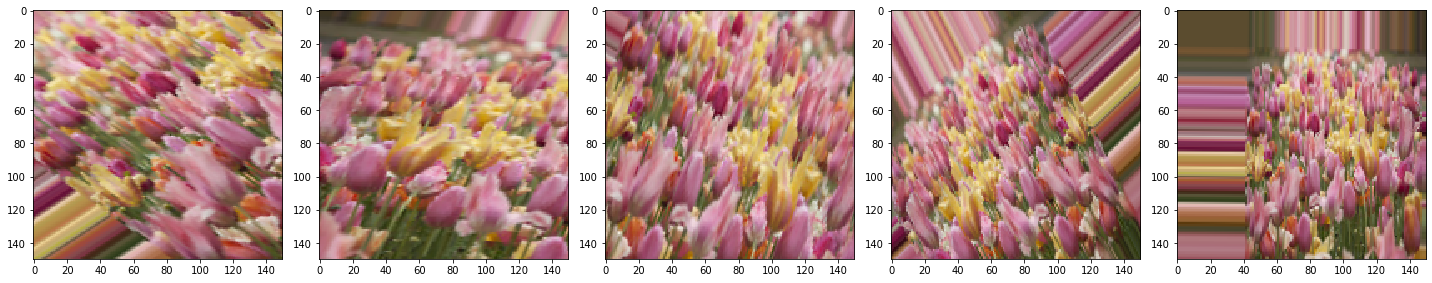

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Create CNN**

In [0]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(16, (3,3), activation = 'relu', input_shape = (IMG_SHAPE, IMG_SHAPE, 3)),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
                                    tf.keras.layers.MaxPooling2D(2,2),

                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(units = 512, activation='relu'),
                                    tf.keras.layers.Dense(units = 5, activation='softmax')

])

**Compile the Model**

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Model Summary**

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 64)        0

**Train the Model**

In [0]:
epochs = 20
history = model.fit_generator(train_data_gen,
                              steps_per_epoch = int(np.ceil(train_temp/float(BATCH_SIZE))),
                              epochs = epochs,
                              validation_data = val_data_gen,
                              validation_steps = int(np.ceil(val_temp/float(BATCH_SIZE)))
                              )

Epoch 1/20
30/30 [==============================] - 24s 813ms/step - loss: 1.6743 - accuracy: 0.2801 - val_loss: 1.3459 - val_accuracy: 0.4082
Epoch 2/20
30/30 [==============================] - 22s 720ms/step - loss: 1.2329 - accuracy: 0.4722 - val_loss: 1.1431 - val_accuracy: 0.5306
Epoch 3/20
30/30 [==============================] - 21s 705ms/step - loss: 1.1064 - accuracy: 0.5516 - val_loss: 1.0418 - val_accuracy: 0.5932
Epoch 4/20
30/30 [==============================] - 22s 718ms/step - loss: 1.0205 - accuracy: 0.5874 - val_loss: 1.0284 - val_accuracy: 0.6231
Epoch 5/20
30/30 [==============================] - 21s 709ms/step - loss: 0.9701 - accuracy: 0.6191 - val_loss: 0.9607 - val_accuracy: 0.6463
Epoch 6/20
30/30 [==============================] - 21s 711ms/step - loss: 0.9336 - accuracy: 0.6375 - val_loss: 1.0173 - val_accuracy: 0.6068
Epoch 7/20
30/30 [==============================] - 22s 725ms/step - loss: 0.9671 - accuracy: 0.6225 - val_loss: 0.9406 - val_accuracy: 0.6327

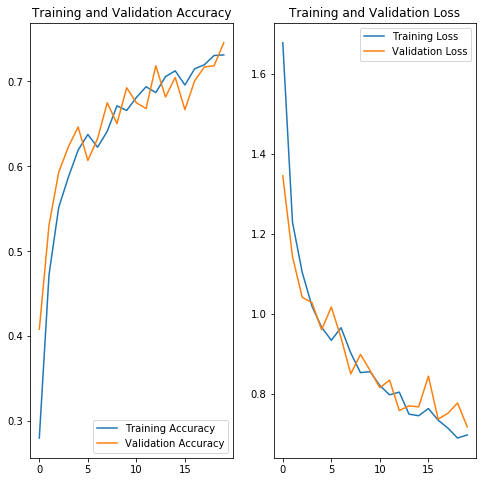

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()